In [1]:
import time
import torch
import warnings
import numpy as np
import matplotlib.pyplot as plt

from pina import Condition, LabelTensor, Trainer
from pina.solver import PINN
from pina.operator import grad
from pina.equation import Equation, FixedValue
from pina.callback import MetricTracker
from pina.domain import CartesianDomain
from pina.problem import SpatialProblem, TimeDependentProblem

In [2]:
# Definición del problema de difusión 1D
class Diffusion(TimeDependentProblem, SpatialProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 1]})
    temporal_domain = CartesianDomain({"t": [0, 1]})
    domains = {
        "g1": CartesianDomain({"x": 1, "t": [0, 1]}),
        "g2": CartesianDomain({"x": 0, "t": [0, 1]}),
        "initial": CartesianDomain({"x": [0, 1], "t": 0}),
        "D": CartesianDomain({"x": [0, 1], "t": [0, 1]}),
    }

    def __init__(self):
        super().__init__()
        self.k = torch.nn.Parameter(torch.tensor(0.01))
        self.amplitudes = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(1) * 0.5) for _ in range(3)])
        
        

    # Ecuación de advección
    def diffusion_eq(self, input_, output_):

        # Ecuación de advección: u_t - k * u_xx = 0
        
        u_t = grad(output_, input_, components=["u"], d=["t"])
        u_x = grad(output_, input_, components=["u"], d=["x"])
        u_xx = grad(u_x, input_, components=["dudx"], d=["x"])
        return u_t - self.k * u_xx
    
    def initial_condition(self, input_, output_):
        x = input_.extract(["x"])
        u_0 = torch.zeros_like(x)
        for j in range(1, 4):
            u_0 += self.amplitudes[j - 1] * torch.sin(j * torch.pi * x)
        return output_.extract(["u"]) - u_0

    # Solución analítica exacta
    def solution(self, pts):
        x = pts.extract(["x"])
        t = pts.extract(["t"])
        f = torch.zeros_like(x)
        for j in range(1, 4):
            f += self.amplitudes[j - 1] * torch.exp(-(j * torch.pi)**2 * self.k * t) * torch.sin(j * torch.pi * x)
        return LabelTensor(f, self.output_variables)

    # Definimos "conditions" como propiedad
    @property
    def conditions(self):
        return {
            "g1": Condition(domain="g1", equation=FixedValue(0.0)),
            "g2": Condition(domain="g2", equation=FixedValue(0.0)),
            "initial": Condition(domain="initial", equation=Equation(self.initial_condition)),
            "D": Condition(domain="D", equation=Equation(self.diffusion_eq)),
        }

In [3]:
class HardMLP(torch.nn.Module):

    def __init__(self, input_dim, output_dim, amplitudes):
        super().__init__()
        self.amplitudes = amplitudes

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, output_dim),
        )
    
    def u0(self, x):
        
        # Condición inicial u0(x), igual a .initial_condition

        u_0 = torch.zeros_like(x)
        for j in range(1, 4):
            u_0 += self.amplitudes[j - 1] * torch.sin(j * torch.pi * x)
        return u_0
    
    def forward(self, pts):
        x = pts.extract(["x"])
        t = pts.extract(["t"])
        
        hard = x * (1 - x)

        # calculamos u0
        u0 = self.u0(x)

        # salida de la red
        nn = self.layers(pts)

        # imponemos la restricción dura
        u_pinn = u0 + t * hard * nn
        return u_pinn

In [4]:
def FDM(amplitudes, k):
    # Parámetros físicos y numéricos
    L = 1.0                # longitud del dominio
    k = k.tolist()         # coeficiente de difusión
    
    Nx = 300               # número de puntos en x
    Nt = 2230               # número de pasos de tiempo
    dx = L / (Nx - 1)
    dt = 0.4 * dx**2 / k   # condición de estabilidad CFL para FTCS
        
    # Mallado
    x = np.linspace(0, L, Nx)

    # ---- Condición inicial ----
    u0 = np.zeros(Nx)
    for j in range(1, 4):
            u0 += amplitudes[j - 1].tolist() * np.sin(j * np.pi * x)
    
    # Solución numérica
    u=u0.copy()
    u_new = np.zeros(Nx) # siguiente paso
    
    # ---- Condiciones de borde ----
    # u(0,t) = u(L,t) = 0   (Dirichlet)
    def apply_boundary(u):
        u[0] = 0
        u[-1] = 0
        return u
    
    apply_boundary(u)
    
    # Constante del esquema
    alpha = k * dt / dx**2
    
    # Verificación por seguridad
    if alpha > 0.5:
        print("ADVERTENCIA: el esquema puede ser inestable (alpha > 0.5).")
    
    # Evolución temporal
    for n in range(Nt):
        # aplicar esquema FTCS
        for i in range(1, Nx - 1):
            u_new[i] = u[i] + alpha * (u[i+1] - 2*u[i] + u[i-1])
    
        # aplicar condiciones de borde
        apply_boundary(u_new)
    
        # actualizar
        u[:] = u_new[:]
    return x, u

In [5]:
# Definimos el problema
problem = Diffusion()

# Generamos los datos
problem.discretise_domain(1000, "random", domains="all")

# Definimos el modelo
model = HardMLP(
    input_dim=2,  # x, t
    output_dim=1,
    amplitudes=problem.amplitudes
)

# Definimos la solución
solver = PINN(problem=problem, model=model)

In [6]:
print("Input vars:", problem.input_variables)
print("Output vars:", problem.output_variables)
print("Model input dim:", len(problem.input_variables))
print("Model output dim:", len(problem.output_variables))

Input vars: ['x', 't']
Output vars: ['u']
Model input dim: 2
Model output dim: 1


In [7]:
# create trainer and train
trainer = Trainer(
    solver=solver,
    max_epochs=1001,
    accelerator="cpu",
    enable_model_summary=False,
    train_size=0.7,
    val_size=0.2,
    test_size=0.1,
    callbacks=[MetricTracker(["train_loss", "initial_loss", "D_loss"])],
)
start = time.perf_counter()
trainer.train()
end = time.perf_counter()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\brian\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\brian\miniconda3\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
C:\Users\brian\miniconda3\Lib\site-packages\pina\s

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1001` reached.


Entrenamiento duró 1.430 minutos


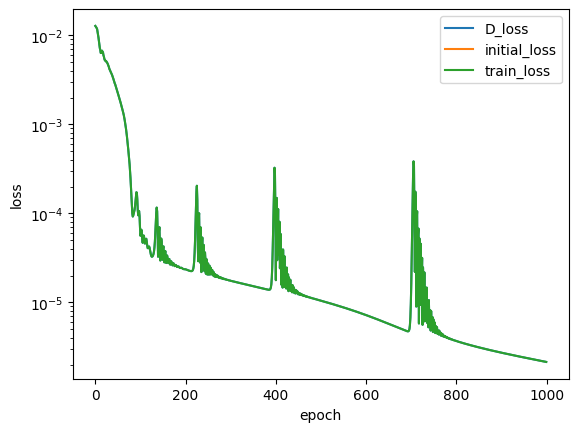

In [8]:
trainer_metrics = trainer.callbacks[0].metrics
for metric, loss in trainer_metrics.items():
    plt.plot(range(len(loss)), loss, label=metric)
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
minutes = (end - start)/60
print(f"Entrenamiento duró {minutes:.3f} minutos")

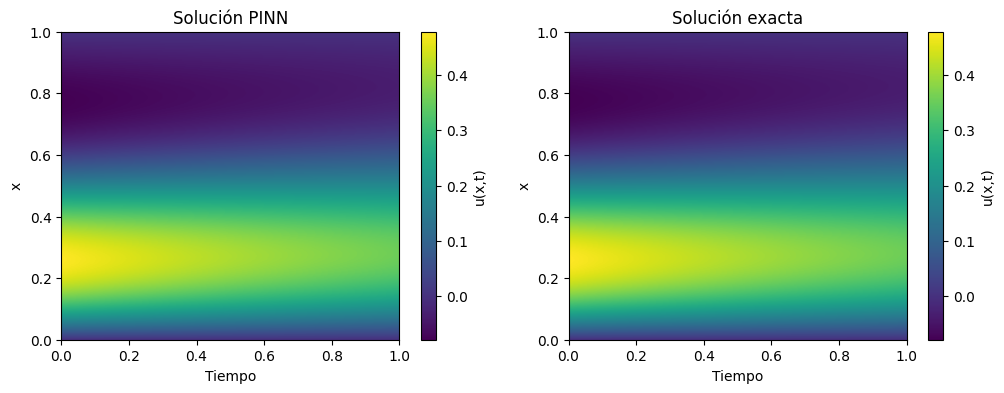

In [9]:
x = problem.spatial_domain.sample(300, "grid")
t = problem.temporal_domain.sample(300, "grid")
points = x.append(t, mode="cross")  # 100 × 100 = 10 000 puntos

with torch.no_grad():
    u_pred = solver.model(points)
U_pred = u_pred.detach().cpu().numpy().reshape(300, 300)
U_true = problem.solution(points).detach().cpu().numpy().reshape(300, 300)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Solución PINN")
plt.imshow(U_pred.T, origin="lower", extent=[0, 1, 0, 1], aspect="auto")
plt.colorbar(label="u(x,t)")
plt.xlabel("Tiempo")
plt.ylabel("x")

plt.subplot(1, 2, 2)
plt.title("Solución exacta")
plt.imshow(U_true.T, origin="lower", extent=[0, 1, 0, 1], aspect="auto")
plt.colorbar(label="u(x,t)")
plt.xlabel("Tiempo")
plt.ylabel("x")
plt.show()

Error DF:0.00000002, Error PINN:0.00000006


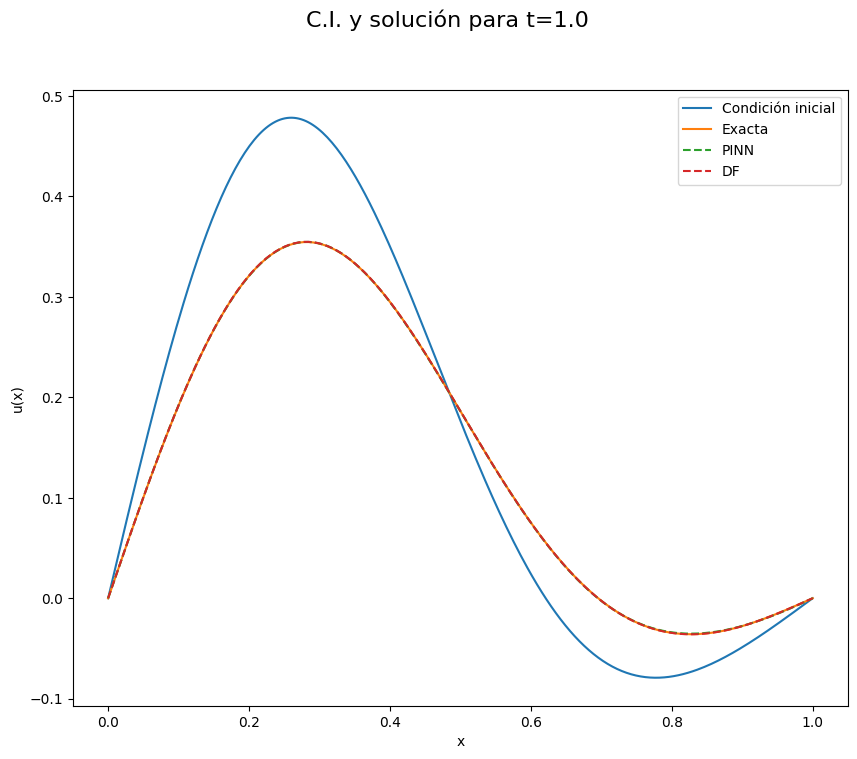

In [10]:
time_0 = LabelTensor(torch.tensor([[0]]), "t")
time_1 = LabelTensor(torch.tensor([[1]]), "t")

points_0 = x.append(time_0, mode="cross")
points_1 = x.append(time_1, mode="cross")

with torch.no_grad():
    u_pred = solver.model(points_1)
u_pred = u_pred.detach().cpu().numpy().flatten()

u_true_0 = problem.solution(points_0).detach().cpu().numpy().flatten()
u_true_1 = problem.solution(points_1).detach().cpu().numpy().flatten()
x_fdm, u_fdm =FDM(problem.amplitudes, problem.k)

error_fdm = u_true_1 - u_fdm
error_pinn = u_true_1 - u_pred
mse_fdm = np.mean(error_fdm**2)
mse_pinn = np.mean(error_pinn**2)
print(f"Error DF:{mse_fdm:.8f}, Error PINN:{mse_pinn:.8f}")

plt.figure(figsize=(10, 8))
plt.suptitle("C.I. y solución para t=1.0", fontsize=16)
plt.plot(x, u_true_0, label="Condición inicial")
plt.plot(x, u_true_1, label="Exacta")
plt.plot(x, u_pred, "--", label="PINN")
plt.plot(x_fdm, u_fdm, "--", label="DF")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()

In [11]:
print(problem.amplitudes[0].tolist(), problem.amplitudes[1].tolist(), problem.amplitudes[2].tolist())

[0.2298649102449417] [0.277348130941391] [0.0533885583281517]


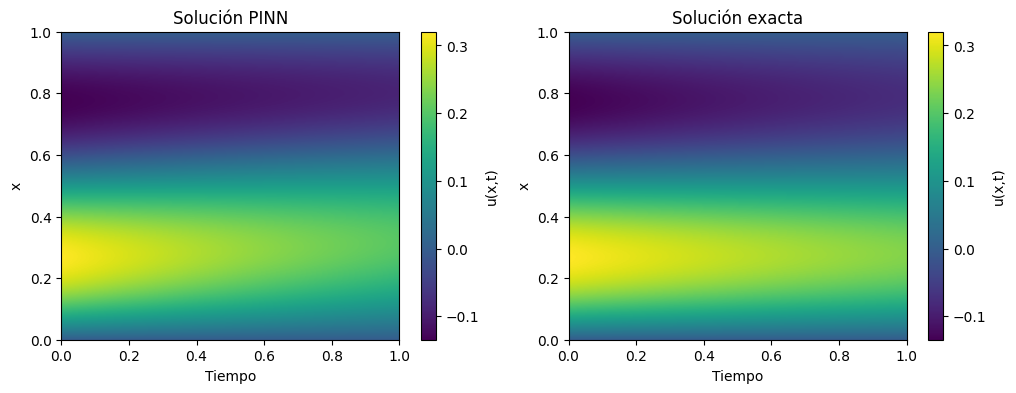

In [12]:
problem_test = Diffusion()  # Nueva instancia → nuevos valores de amplitudes/fases

# 1) copiar amplitudes y phases del problema nuevo al modelo
solver.model.amplitudes = problem_test.amplitudes
#solver.model.phases = problem_test.phases
solver.model.k = problem_test.k

# 2) evaluar sobre nuevos puntos
x_test = problem_test.spatial_domain.sample(300, "grid")
t_test = problem_test.temporal_domain.sample(300, "grid")
points_test = x_test.append(t_test, mode="cross")

with torch.no_grad():
    u_pred = solver.model(points_test)

U_pred = u_pred.detach().cpu().numpy().reshape(300, 300)
U_true = problem_test.solution(points_test).detach().cpu().numpy().reshape(300, 300)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Solución PINN")
plt.imshow(U_pred.T, origin="lower", extent=[0, 1, 0, 1], aspect="auto")
plt.colorbar(label="u(x,t)")
plt.xlabel("Tiempo")
plt.ylabel("x")

plt.subplot(1, 2, 2)
plt.title("Solución exacta")
plt.imshow(U_true.T, origin="lower", extent=[0, 1, 0, 1], aspect="auto")
plt.colorbar(label="u(x,t)")
plt.xlabel("Tiempo")
plt.ylabel("x")
plt.show()

Error DF:0.00000001, Error PINN:0.00049471


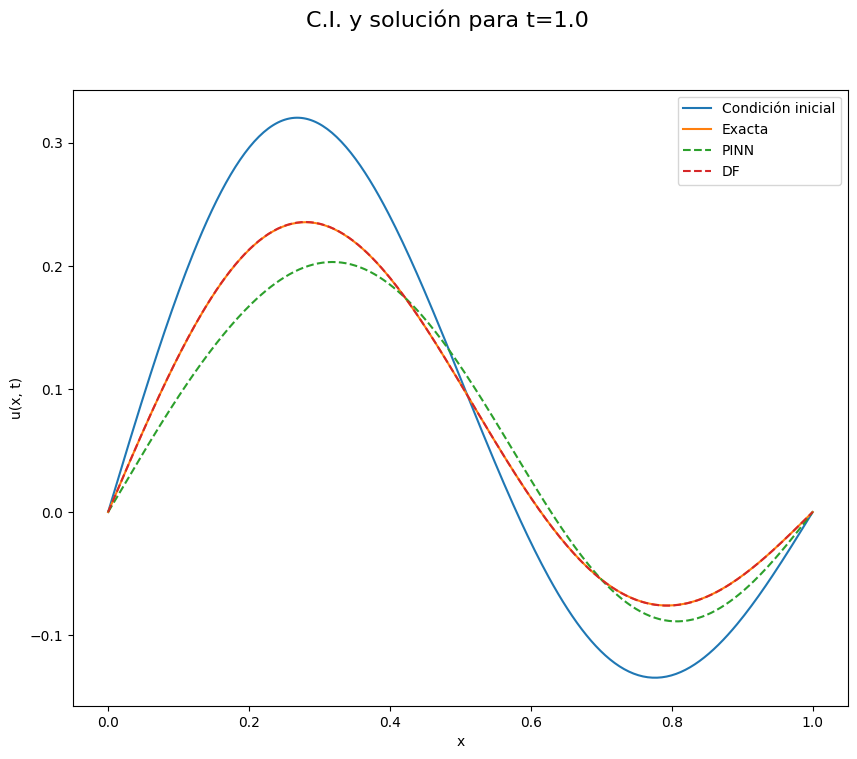

In [13]:
time_0 = LabelTensor(torch.tensor([[0]]), "t")
time_1 = LabelTensor(torch.tensor([[1]]), "t")

points_test_0 = x_test.append(time_0, mode="cross")
points_test_1 = x_test.append(time_1, mode="cross")

with torch.no_grad():
    U_pred_0 = solver.model(points_test_0)
    U_pred_1 = solver.model(points_test_1)
U_pred_0 = U_pred_0.detach().cpu().numpy().flatten()
U_pred_1 = U_pred_1.detach().cpu().numpy().flatten()

U_true_0 = problem_test.solution(points_test_0).detach().cpu().numpy().flatten()
U_true_1 = problem_test.solution(points_test_1).detach().cpu().numpy().flatten()

x_fdm, u_fdm = FDM(problem_test.amplitudes, problem_test.k)

error_fdm = U_true_1 - u_fdm
error_pinn = U_true_1 - U_pred_1
mse_fdm = np.mean(error_fdm**2)
mse_pinn = np.mean(error_pinn**2)
print(f"Error DF:{mse_fdm:.8f}, Error PINN:{mse_pinn:.8f}")

plt.figure(figsize=(10, 8))
plt.suptitle("C.I. y solución para t=1.0", fontsize=16)
plt.plot(x_test, U_true_0, label="Condición inicial")
plt.plot(x_test, U_true_1, label="Exacta")
plt.plot(x_test, U_pred_1, "--", label="PINN")
plt.plot(x_fdm, u_fdm, "--", label="DF")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

In [15]:
print(problem_test.amplitudes[0].tolist(), problem_test.amplitudes[1].tolist(), problem_test.amplitudes[2].tolist())

[0.12032857537269592] [0.22531947493553162] [0.011510848999023438]
